## Gradient Boosting Machines with XGBoost(GBMs) and LightGBM Algorithm for classification 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

store_df = pd.read_csv('../data/RossmanStores/store.csv')
train_df = pd.read_csv('../data/RossmanStores/train.csv')
test_df = pd.read_csv('../data/RossmanStores/test.csv')

store_df.head()

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6924\2621352464.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('../data/RossmanStores/train.csv')


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [2]:
merged_df = train_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

## Preprocessing and Feature Engineering

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [4]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

split_date(merged_df)
split_date(merged_test_df)

In [5]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [6]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [7]:
merged_df.shape

(844392, 22)

### Competition 

Create a feature that tells how many months the competing store has been open.

In [8]:
def competition_months(df):
    df['CompetitionOpen'] = (12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df.Month - df['CompetitionOpenSinceMonth']))
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

competition_months(merged_df)
competition_months(merged_test_df)

In [9]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) * 4.34524
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']

    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [10]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [11]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
356314,2014-08-25,0,NaN,NaN,NaN,0.00000,0
54654,2015-06-12,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.00000,0
914541,2013-04-03,1,2011.0,40.0,"Jan,Apr,Jul,Oct",0.00000,0
347956,2014-09-03,1,2012.0,22.0,"Jan,Apr,Jul,Oct",84.83336,0
443185,2014-05-30,1,2014.0,18.0,"Mar,Jun,Sept,Dec",17.38096,0
735514,2013-09-10,1,2011.0,14.0,"Jan,Apr,Jul,Oct",123.94052,0
438779,2014-06-03,1,2011.0,35.0,"Feb,May,Aug,Nov",0.00000,0
56635,2015-06-11,0,NaN,NaN,NaN,0.00000,0
709002,2013-10-04,0,NaN,NaN,NaN,0.00000,0
48102,2015-06-18,1,2009.0,31.0,"Feb,May,Aug,Nov",45.92856,0


### Input and Target Columns

Let's select the columns that we'll use for training.

In [12]:
merged_df.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [13]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [14]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
test_inputs = merged_test_df[input_cols].copy()

targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [15]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

## Impute missing numerical data


In [16]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [17]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

In [18]:
max_distance = inputs.CompetitionDistance.max()
max_distance

np.float64(75860.0)

In [19]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6924\733699737.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
C:\Users\DILSHOD\AppData\Local\Temp\ipykernel_6924\733699737.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [20]:
for col in categorical_cols:
    inputs[col] = inputs[col].astype(str)
    test_inputs[col] = test_inputs[col].astype(str)


inputs['DayOfWeek'] = inputs['DayOfWeek'].astype(str)

inputs[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DayOfWeek     844392 non-null  object
 1   StateHoliday  844392 non-null  object
 2   StoreType     844392 non-null  object
 3   Assortment    844392 non-null  object
dtypes: object(4)
memory usage: 32.2+ MB


## Scaling Numeric Data

In [21]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

scaler = MinMaxScaler()
inputs[numeric_cols] = scaler.fit_transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.fit_transform(test_inputs[numeric_cols])

In [22]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


## Training

In [23]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)


In [24]:
model.fit(X, targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [25]:
preds = model.predict(X)
preds

array([7965.1343, 7834.3423, 8566.92  , ..., 8611.509 , 7570.4385,
       9383.83  ], shape=(844392,), dtype=float32)

In [26]:
from sklearn.metrics import mean_squared_error
import math

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

In [27]:
rmse(targets, preds)

2074.8856595003012

(array([5.760e+02, 4.568e+03, 3.417e+03, 9.980e+02, 2.870e+02, 1.020e+02,
        3.300e+01, 1.500e+01, 2.000e+00, 2.000e+00]),
 array([    0. ,  3236.8,  6473.6,  9710.4, 12947.2, 16184. , 19420.8,
        22657.6, 25894.4, 29131.2, 32368. ]),
 <BarContainer object of 10 artists>)

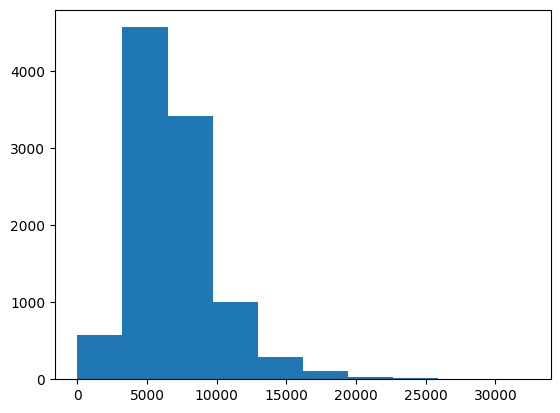

In [28]:
plt.hist(merged_df.Sales.sample(10000))

In [29]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 5,5

In [30]:
# plot_tree(model, rankdir='LR', num_trees=0)

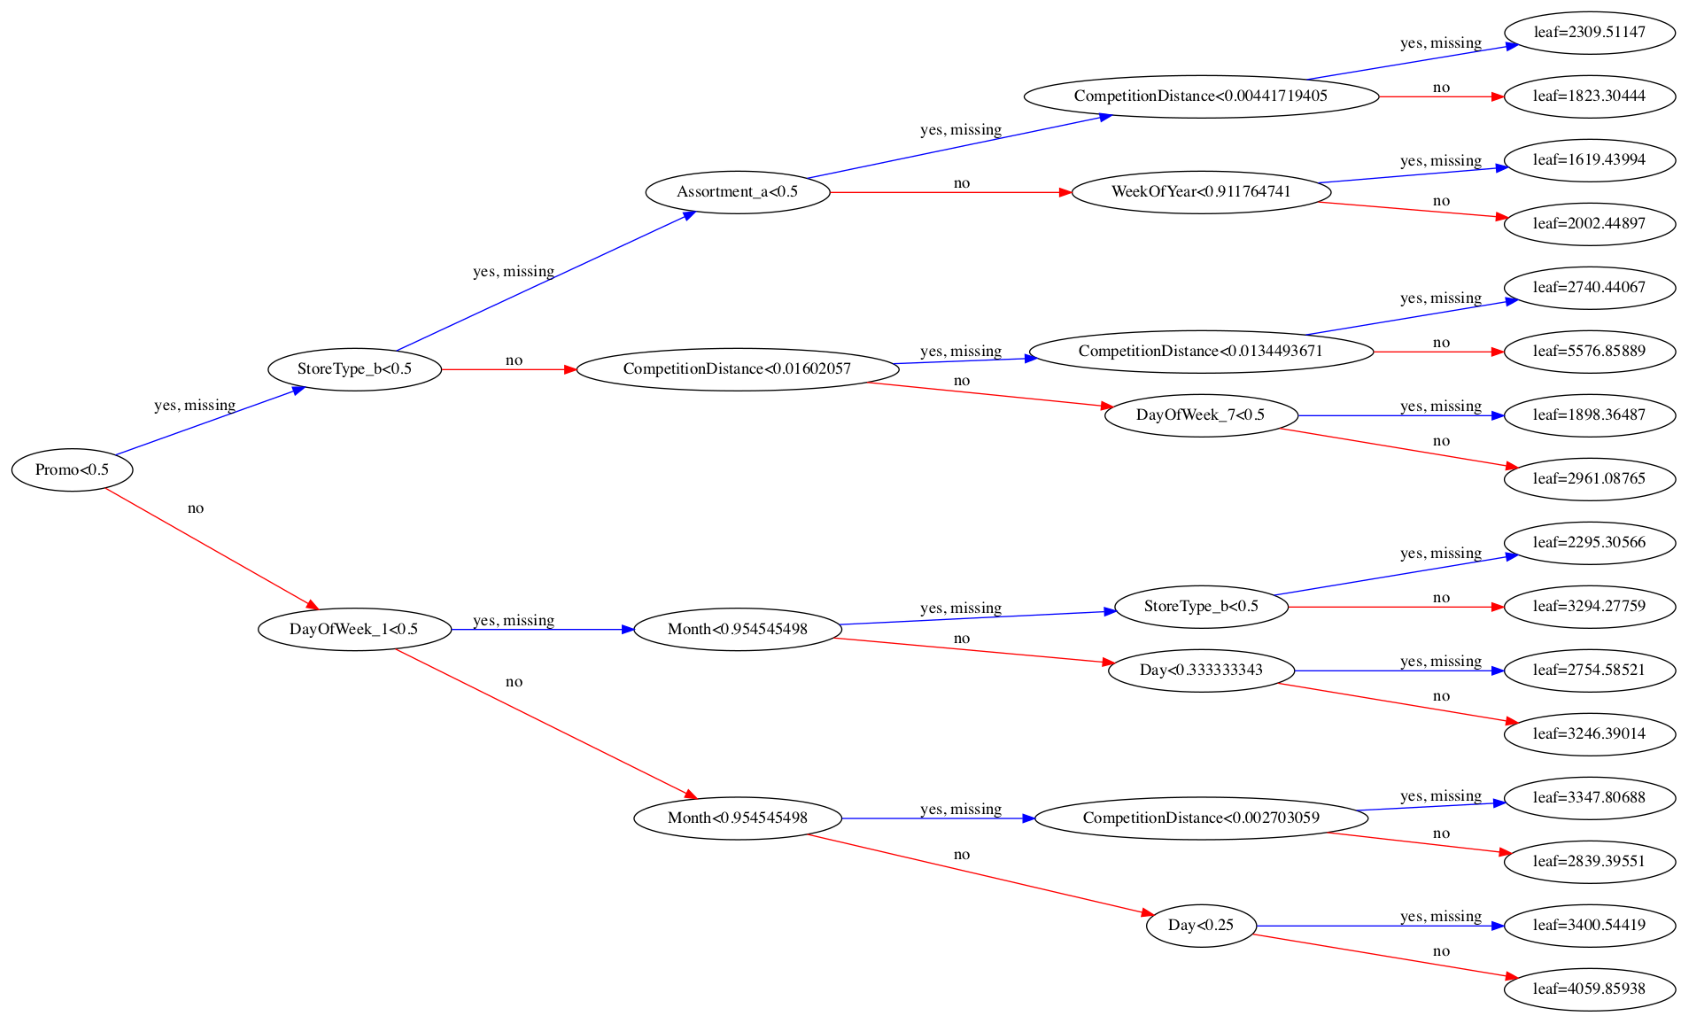

In [31]:
trees = model.get_booster().get_dump()
print(trees)

['0:[Promo<1] yes=1,no=2,missing=2\n\t1:[StoreType_b<1] yes=3,no=4,missing=4\n\t\t3:[Assortment_a<1] yes=7,no=8,missing=8\n\t\t\t7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16\n\t\t\t\t15:leaf=181.975769\n\t\t\t\t16:leaf=-259.831238\n\t\t\t8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18\n\t\t\t\t17:leaf=-467.055237\n\t\t\t\t18:leaf=-83.930191\n\t\t4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10\n\t\t\t9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20\n\t\t\t\t19:leaf=654.354065\n\t\t\t\t20:leaf=3492.14575\n\t\t\t10:[DayOfWeek_7<1] yes=21,no=22,missing=22\n\t\t\t\t21:leaf=-187.357132\n\t\t\t\t22:leaf=877.194702\n\t2:[DayOfWeek_1<1] yes=5,no=6,missing=6\n\t\t5:[Month<1] yes=11,no=12,missing=12\n\t\t\t11:[StoreType_b<1] yes=23,no=24,missing=24\n\t\t\t\t23:leaf=208.808884\n\t\t\t\t24:leaf=1208.23828\n\t\t\t12:[Day<0.200000003] yes=25,no=26,missing=26\n\t\t\t\t25:leaf=668.335449\n\t\t\t\t26:leaf=1160.14038\n\t\t6:[Month<1] yes=13,no=14,missing=14\n\

## Importance Features

In [32]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

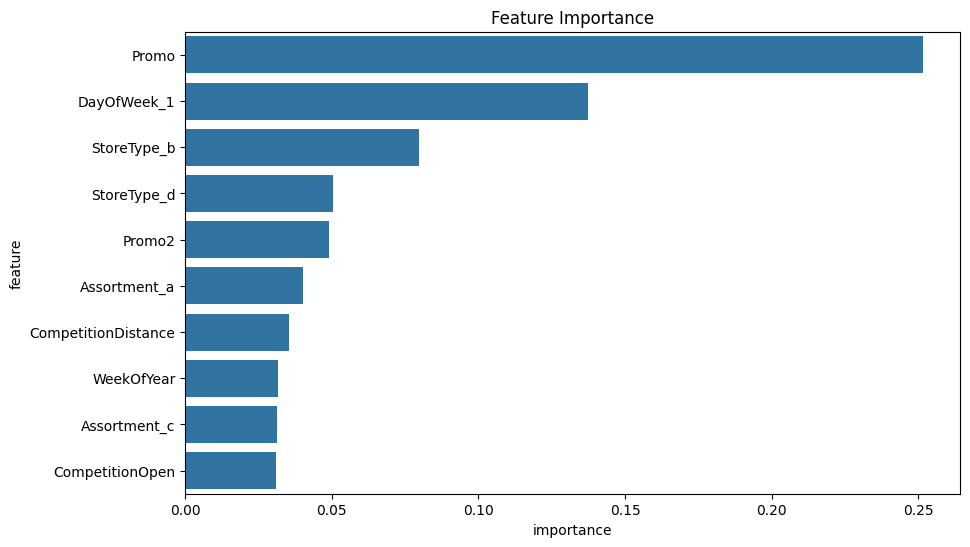

In [33]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [34]:
from sklearn.model_selection import KFold

def train_and_evaluate(X_train, train_targets, x_vals, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(x_vals), val_targets)
    return model, train_rmse, val_rmse
    
kfold = KFold(n_splits=5, shuffle=True)

models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))


Train RMSE: 2395.205523540725, Validation RMSE: 2400.759463169936
Train RMSE: 2443.147866994546, Validation RMSE: 2448.975500081616
Train RMSE: 2422.015999121393, Validation RMSE: 2421.416837308273
Train RMSE: 2397.4510422530007, Validation RMSE: 2387.2286233203554
Train RMSE: 2365.7027497130744, Validation RMSE: 2374.672714291382


In [35]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

predict_avg(models, X)

array([8000.6   , 7628.5986, 8039.    , ..., 7359.087 , 7516.453 ,
       9575.041 ], shape=(844392,), dtype=float32)

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return train_rmse, val_rmse

In [41]:
res = []
for i in range(1, 250, 10):
    train_rmse, val_rmse = test_params(n_estimators=i)
    res.append({
        'n_estimators': i + 1,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    }
    )
    
print(pd.DataFrame(res))

    n_estimators   train_rmse     val_rmse
0              2  2860.921268  2853.136607
1             12  2342.334092  2335.888696
2             22  2042.239641  2034.835743
3             32  1848.063581  1841.431848
4             42  1641.181739  1636.903555
5             52  1529.224804  1525.511799
6             62  1410.155089  1406.570341
7             72  1348.070287  1346.112458
8             82  1286.524339  1286.494316
9             92  1226.358940  1226.490063
10           102  1186.996051  1188.541280
11           112  1138.150089  1141.152488
12           122  1102.689666  1106.659049
13           132  1081.380252  1085.814211
14           142  1058.712130  1063.737985
15           152  1033.418901  1039.379382
16           162  1016.953078  1023.598737
17           172   995.184562  1003.093590
18           182   982.155092   990.753123
19           192   966.291784   975.146880
20           202   956.671410   965.768153
21           212   943.969676   954.079694
22         

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [42]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [43]:
model.fit(X, targets)
test_preds = model.predict(X_test)
submission_df = pd.read_csv('../data/RossmanStores/submission.csv')
submission_df['Sales']  = test_preds
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df


,Unnamed: 0,Id,Sales
0,0,1,6364.349609
1,1,2,10395.020508
2,2,3,12463.082031
3,3,4,6051.066895
4,4,5,8297.277344
...,...,...,...
41083,41083,41084,2265.708008
41084,41084,41085,8194.600586
41085,41085,41086,5579.001953
41086,41086,41087,22085.873047
